# 7 - application of unsupervised learning

# Description du problème :
Les détails suivants proviennent de la description du jeu de données Kaggle et de ce notebook :\
https://www.kaggle.com/code/helenakolbanova/hierarchical-and-kmeans-multiple-dist-metrics :
"
## À propos du jeu de données

Nous allons regrouper des données anonymisées de patients ayant été diagnostiqués avec une maladie cardiaque.\
Les patients ayant des caractéristiques similaires pourraient répondre aux mêmes traitements,\
et les médecins pourraient bénéficier de l'apprentissage des résultats de traitement des patients qu'ils traitent.\
Les données que nous analysons proviennent du V.A. Medical Center à Long Beach, CA.

## Contenu

Le jeu de données comprend les caractéristiques suivantes :

- **age**: Âge du patient
- **sex**: Sexe du patient
- **cp**: Type de douleur thoracique
- **trestbps**: Pression artérielle au repos (en mm Hg à l'admission à l'hôpital)
- **chol**: Cholestérol sérique en mg/dl
- **fbs**: Glycémie à jeun > 120 mg/dl (1 = vrai; 0 = faux)
- **restecg**: Résultats de l'électrocardiogramme au repos
- **thalach**: Fréquence cardiaque maximale atteinte
- **exang**: Angine induite par l'exercice (1 = oui; 0 = non)
- **oldpeak**: Dépression ST induite par l'exercice par rapport au repos
- **slope**: La pente du segment ST de l'exercice de pointe

"

#### Techniques utilisées :
- KMeans, principalement, puis comparaisons avec d'autres méthodes
- KMeans avec PCA
- Clustering Agglomératif
- DBSCAN
- Mélange Gaussien

#### Métrique utilisée : 
- Score de Silhouette

#### Jeu de données :
- Nous utilisons le jeu de données "Patients atteints de maladies cardiaques"
- Disponible sur https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients/data

Import des bibliothèques nécessaires

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

Charger les données

In [94]:
data_path = "../data/Unsupervised_learning_datasets_ex7/heart_disease_patients.csv"
data = pd.read_csv(data_path)

# Afficher la taille des données et le nombre de valeurs manquantes
print("Forme des données de base:", data.shape)
data = data.dropna()
print("Forme des données après avoir retiré les valeurs manquante:", data.shape)

Forme des données de base: (303, 12)
Forme des données après avoir retiré les valeurs manquante: (303, 12)


In [95]:
# Afficher les différentes caractéristiques des données qu'on va étudier
print(data.dtypes)

id            int64
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
dtype: object


Toutes les caractéristiques sont de type numérique. Il n'y a pas besoin de les "feature engineer".
On va faire juste une étape de préprocessing très simple

In [96]:
# Supprimer la colonne 'id' car elle n'est pas nécessaire pour le clustering
data = data.drop(columns=['id'])

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

Essayons notre premier clustering, en utilisant KMeans avec un nombre de clusters fixé arbitrairement à 3.

In [97]:
# Appliquer la méthode KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

Pour évaluer notre modèle, nous utilisons le score silhouette de scikit.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Nous affichons également le diagramme "pairplot" pour chaque cluster.

Score de silhouette pour KMeans avec n_clusters = 3: 0.13465085312519884


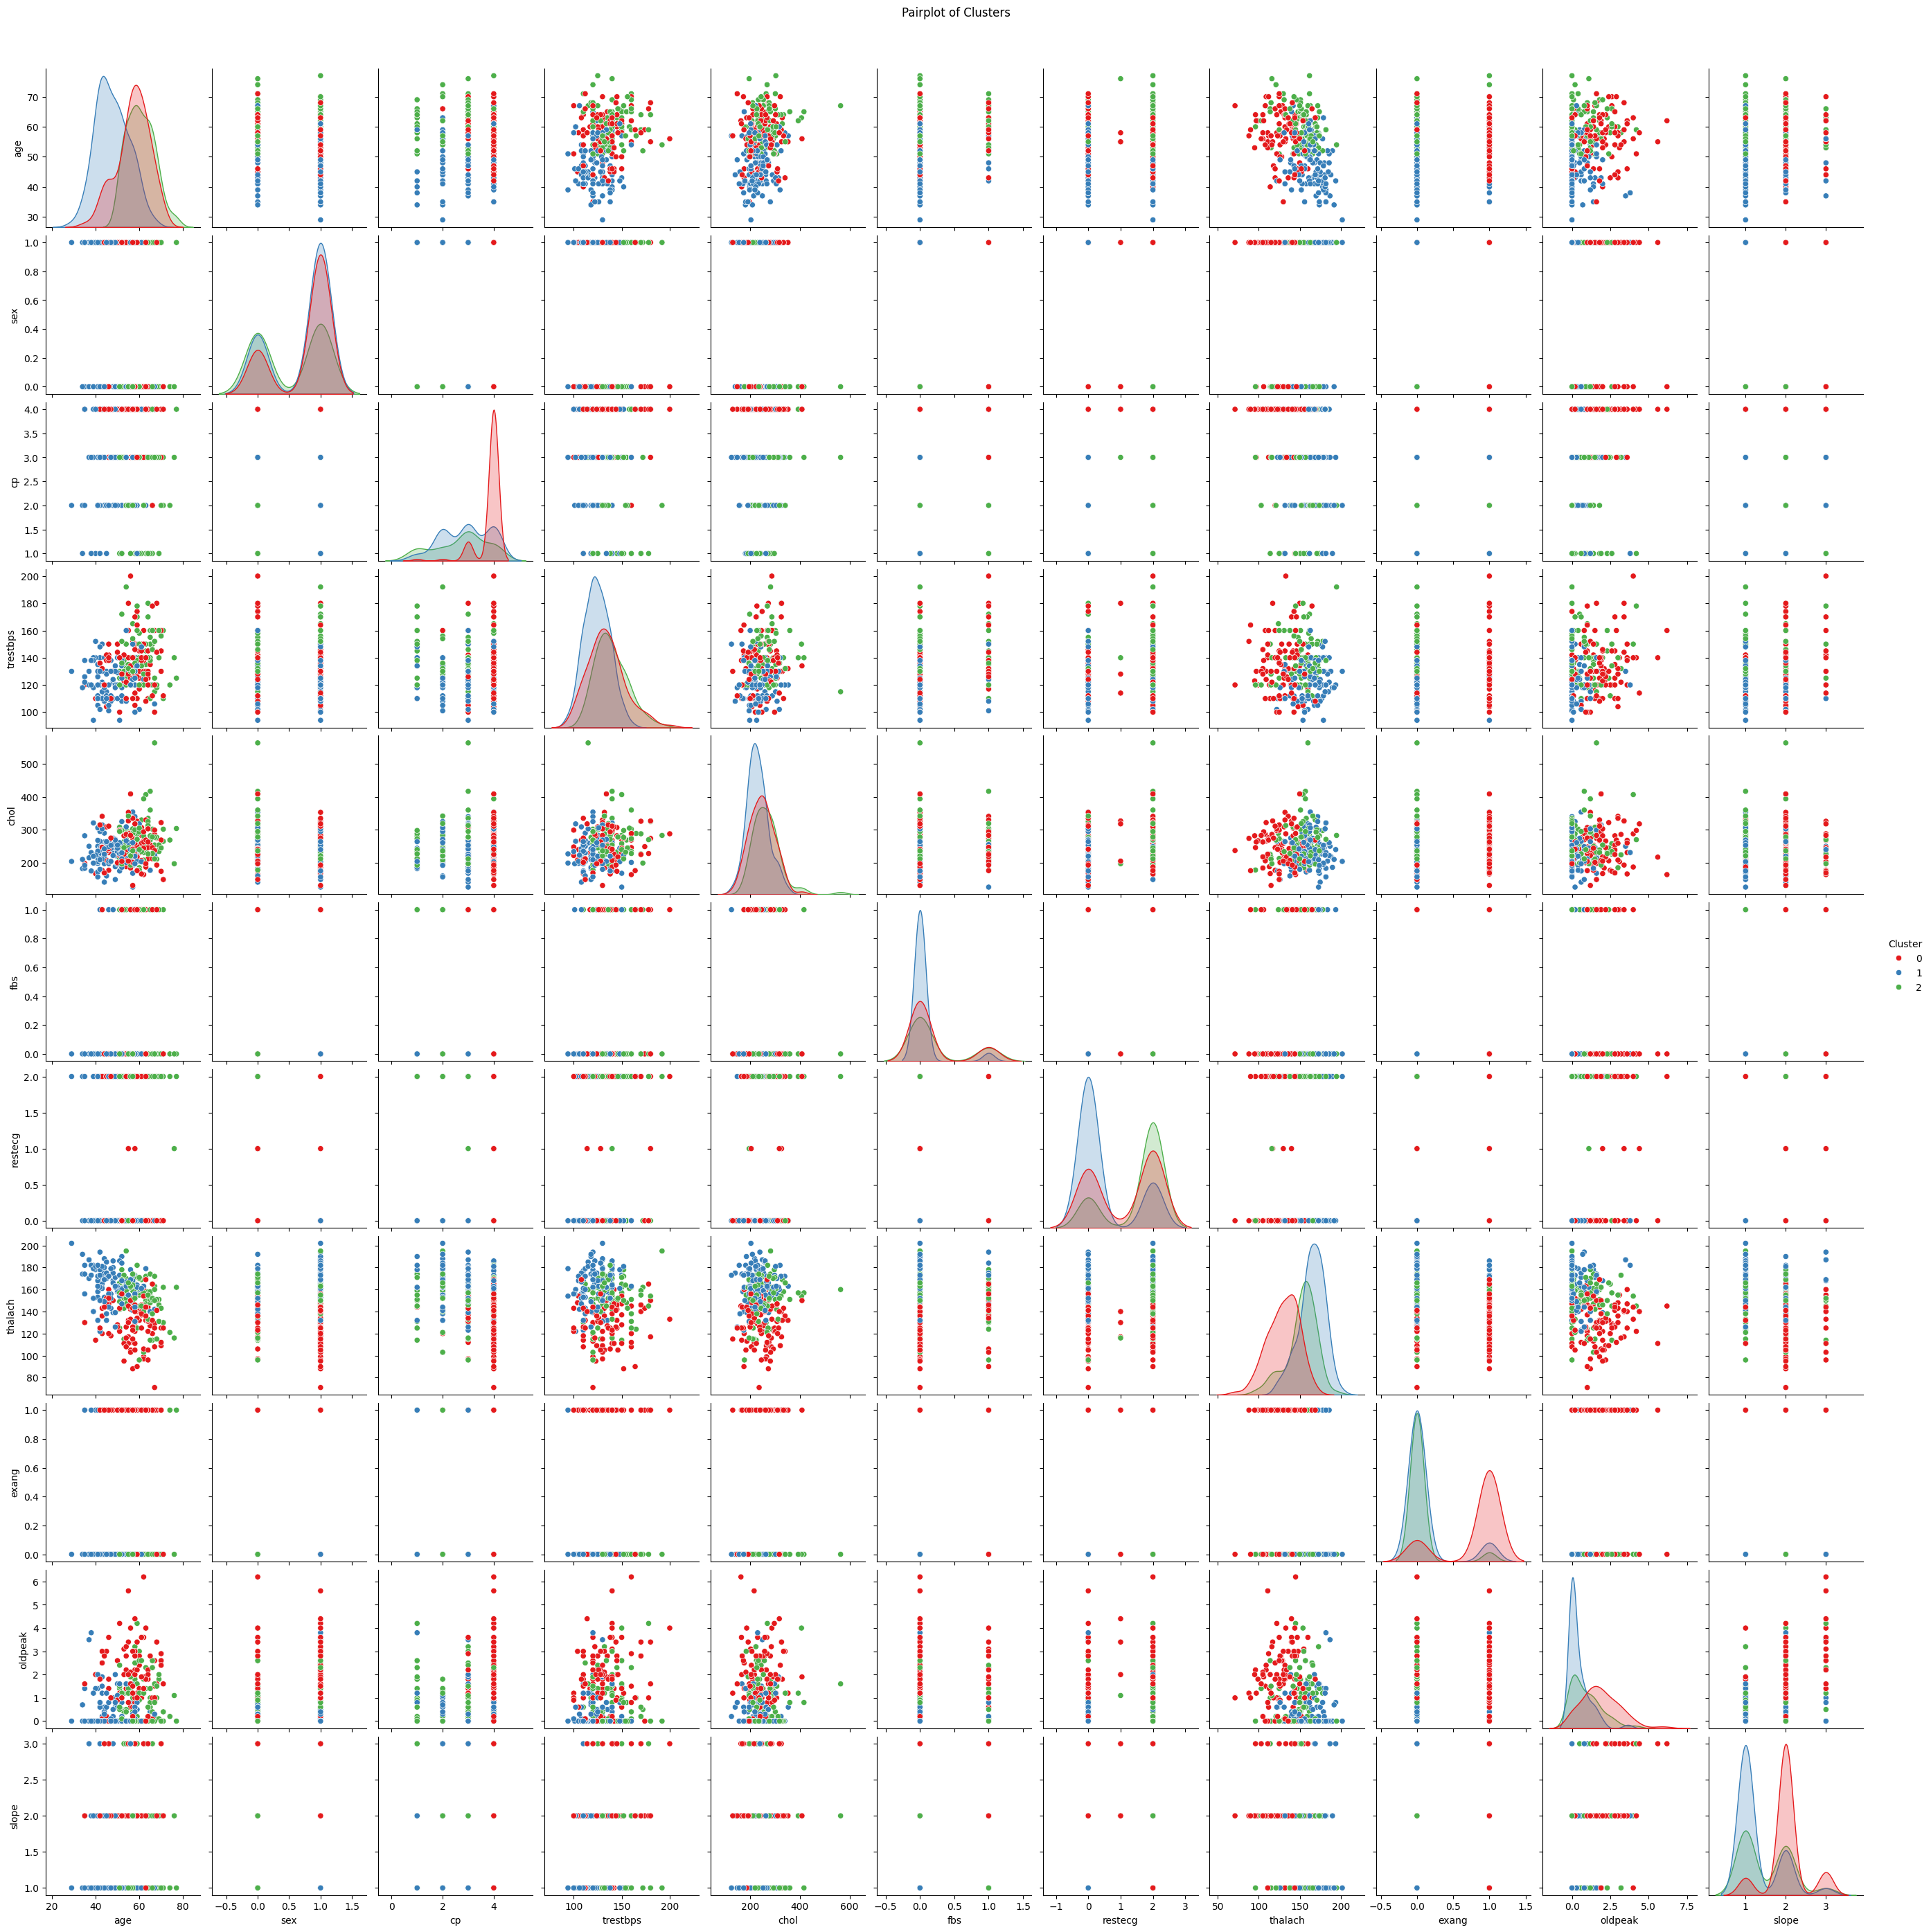

In [98]:
# Calculer du score de silhouette
silhouette_avg = silhouette_score(X_scaled, clusters)
print("Score de silhouette pour KMeans avec n_clusters = 3:", silhouette_avg)

# Ajouter les étiquettes de clusters
data['Cluster'] = clusters

# Afficher les clusters
sns.pairplot(data, hue='Cluster', palette='Set1')
plt.suptitle('Pairplot of Clusters', y=1.02)
plt.show()

Comme il y a trop de caractéristiques, il est difficile de voir clairement ce qu'il se passe.\
De plus, nous ne voyons aucun cas distinct où les trois groupes seraient pertinents.\
Mis à part certains cas comme l'âge/thalach, trestbps/thalach etc.\
Nous allons maintenant voir en détail les clusters qui ont été construits.

In [99]:
# Afficher les tailles des clusters
unique, counts = np.unique(clusters, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"Tailles des clusters: {cluster_sizes}, leur somme est {np.sum(list(cluster_sizes.values()))}")
print(f"La taille des données d'origine est {data.shape[0]}")

Tailles des clusters: {0: 100, 1: 117, 2: 86}, leur somme est 303
La taille des données d'origine est 303


Score moyen de silhouette : 0.13465085312519884


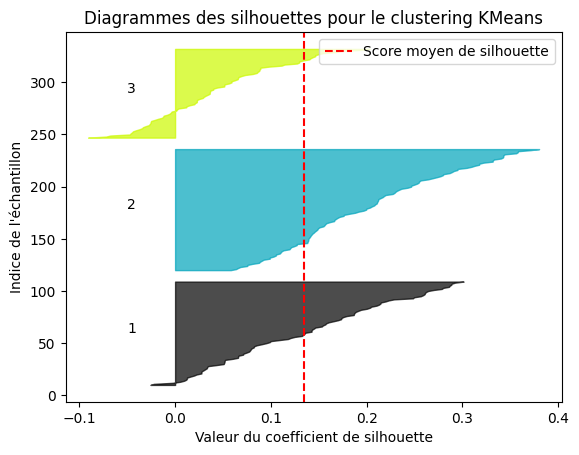

Score moyen de silhouette : 0.13


In [100]:
# Moyenne du Score silhouette des clusters
sample_silhouette_values = silhouette_samples(X_scaled, clusters)
print("Score moyen de silhouette :", silhouette_avg)

# Visualisation des silhouettes
fig, ax = plt.subplots()
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.nipy_spectral(float(i) / 3)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10
ax.set_title("Diagrammes des silhouettes pour le clustering KMeans")
ax.set_xlabel("Valeur du coefficient de silhouette")
ax.set_ylabel("Indice de l'échantillon")
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label='Score moyen de silhouette')
plt.legend(loc='upper right')
plt.show()


print("Score moyen de silhouette :", silhouette_avg.round(2))

Le résultat du score moyen de silhouette est de 0,13, ce qui est très bas.\
Ce score varie entre -1 et 1, et selon cette [discussion](https://www.researchgate.net/post/Threshold_silhouette_score_for_cluster_analysis#:~:text=Typically%2C%20a%20silhouette%20score%20of,assigned%20to):\
"un score de silhouette de 0,5 ou plus est considéré comme indiquant un clustering raisonnablement bon"
Le KMeans utilisé initiallement a nb_clusters = 3, ce qui est peut-être trop bas.\
Essayons donc d'augmenter le nombre de clusters et voyons si le score de silhouette augmente ou non.

Score de silhouette pour 2 clusters : 0.1724141819802903
Score de silhouette pour 7 clusters : 0.12811847436306634
Score de silhouette pour 12 clusters : 0.1171963542790926
Score de silhouette pour 17 clusters : 0.12826966805282955
Score de silhouette pour 22 clusters : 0.13852312017647944
Score de silhouette pour 27 clusters : 0.14041777426194602
Score de silhouette pour 32 clusters : 0.14529896429688682
Score de silhouette pour 37 clusters : 0.1497365817158694
Score de silhouette pour 42 clusters : 0.13775330916098177
Score de silhouette pour 47 clusters : 0.1349060283134194
Score de silhouette pour 52 clusters : 0.14940260660434498
Score de silhouette pour 57 clusters : 0.15298240323055418
Score de silhouette pour 62 clusters : 0.15395467638481444
Score de silhouette pour 67 clusters : 0.16203116328268777
Score de silhouette pour 72 clusters : 0.16610205932556607
Score de silhouette pour 77 clusters : 0.16435753912763093
Score de silhouette pour 82 clusters : 0.16275634992917506
Sco

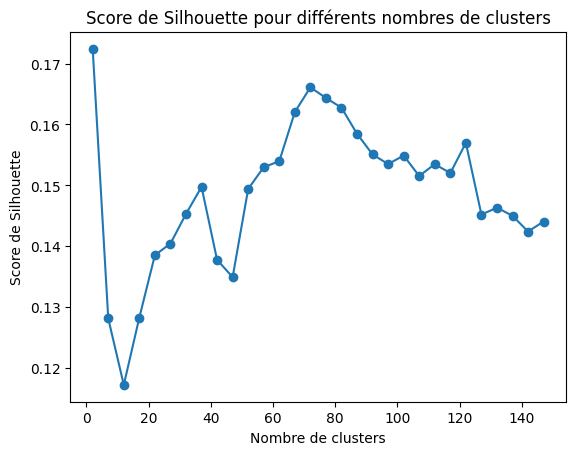

In [101]:
# Affichage des scores de silhouette pour différents nombres de clusters
range_n_clusters = [i for i in range(2, 150, 5)]
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    print(f"Score de silhouette pour {num_clusters} clusters : {silhouette_score(X_scaled, cluster_labels)}")
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette pour différents nombres de clusters')
plt.show()

En utilisant la méthode KMeans, le score silhouette n'évolue pas avec le nombre de clusters.\
Essayons une approche différente, en modifiant comme hyperparamètre, l'algorithme utilisé dans la méthode KMeans.

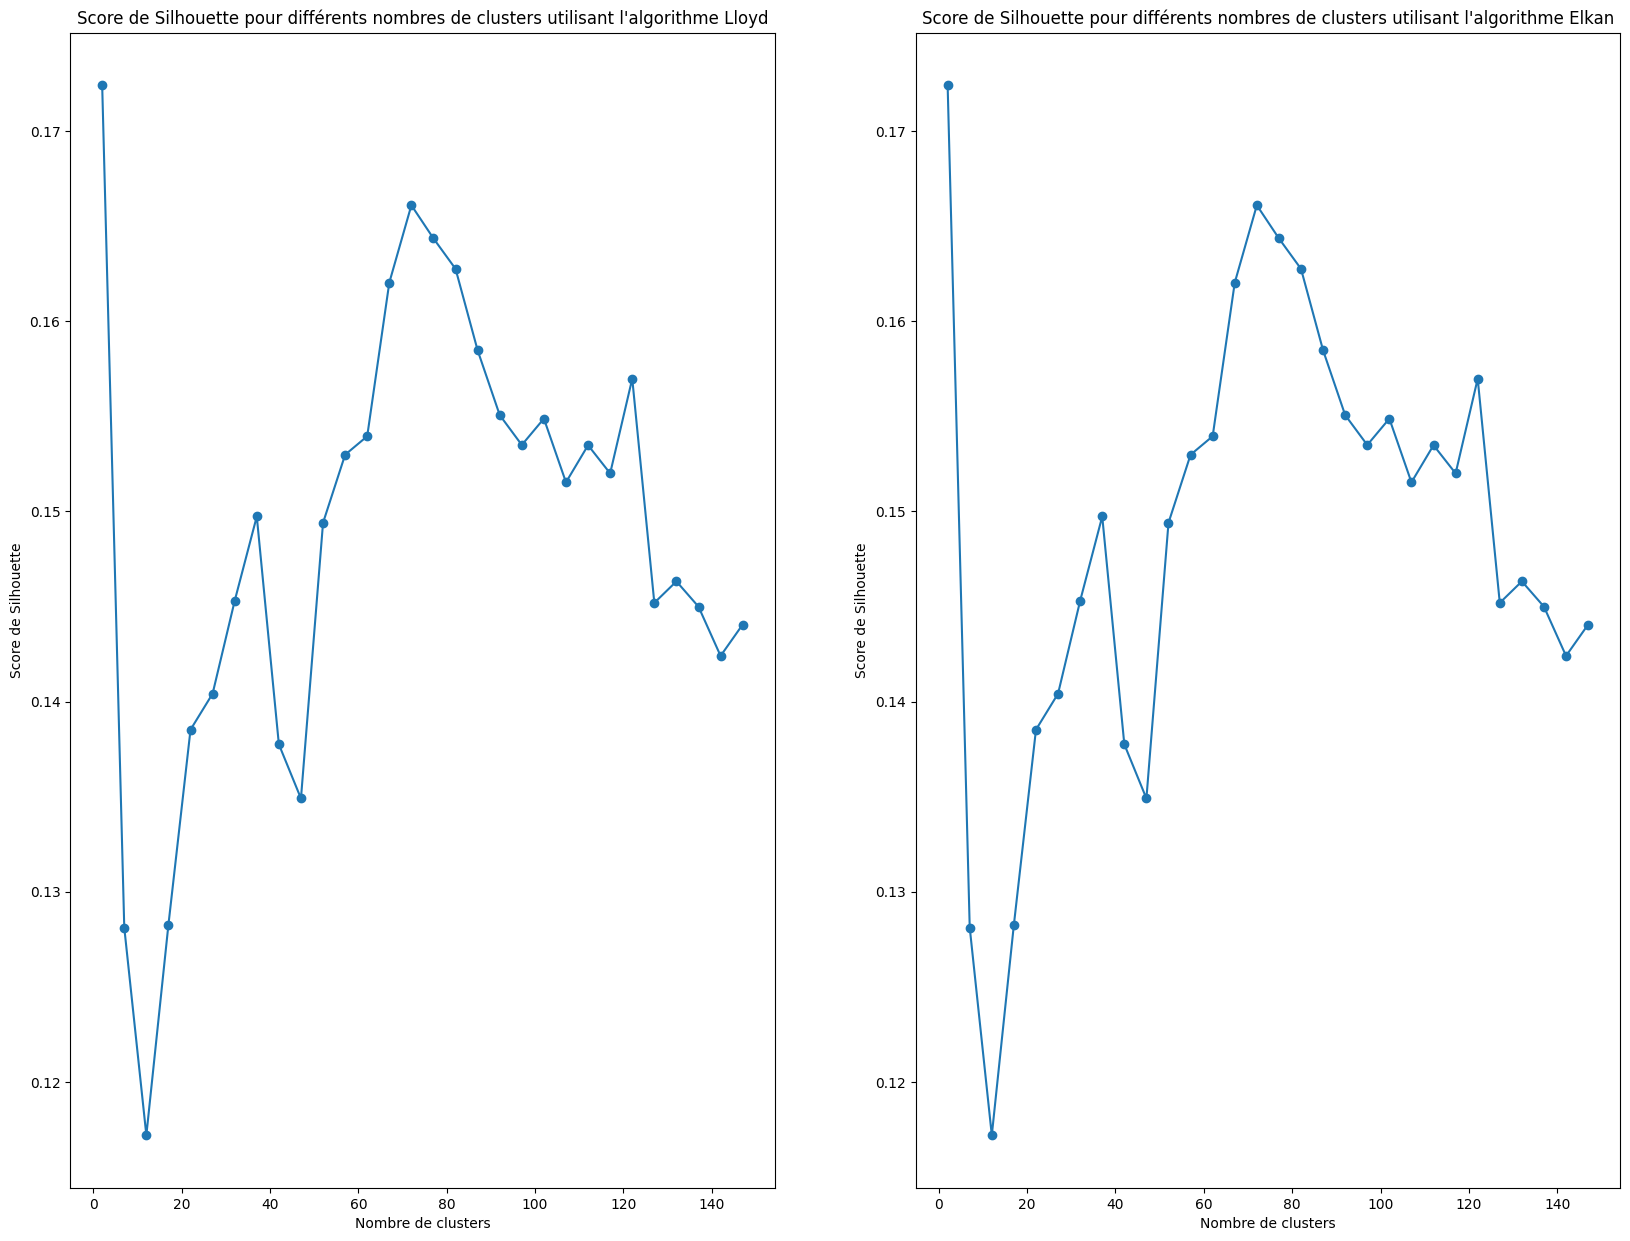

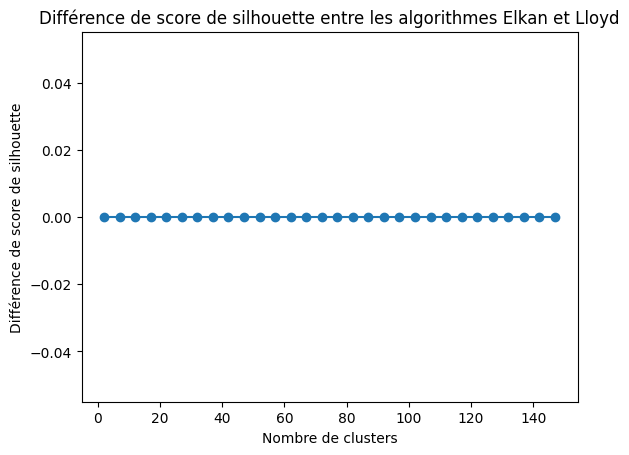

In [102]:
# Affichage des scores de silhouette pour différents nombres de clusters
range_n_clusters = [i for i in range(2, 150, 5)]
lloyd_silhouette_avg = []
elkan_silhouette_avg = []

for num_clusters in range_n_clusters:
    # Utilisation de l'algorithme Lloyd
    lloyd_kmeans = KMeans(n_clusters=num_clusters, random_state=42, algorithm="lloyd")
    lloyd_kmeans.fit(X_scaled)
    lloyd_cluster_labels = lloyd_kmeans.labels_
    lloyd_silhouette_avg.append(silhouette_score(X_scaled, lloyd_cluster_labels))

    # Utilisation de l'algorithme Elkan
    elkan_kmeans = KMeans(n_clusters=num_clusters, random_state=42, algorithm="elkan")
    elkan_kmeans.fit(X_scaled)
    elkan_cluster_labels = elkan_kmeans.labels_
    elkan_silhouette_avg.append(silhouette_score(X_scaled, elkan_cluster_labels))

plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, lloyd_silhouette_avg, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette pour différents nombres de clusters utilisant l\'algorithme Lloyd')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, elkan_silhouette_avg, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette pour différents nombres de clusters utilisant l\'algorithme Elkan')

plt.show()

# Vérifier les différences entre elkan_silhouette_avg et lloyd_silhouette_avg
diff = [elkan_silhouette_avg[i] - lloyd_silhouette_avg[i] for i in range(len(elkan_silhouette_avg))]
plt.plot(range_n_clusters, diff, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Différence de score de silhouette')
plt.title('Différence de score de silhouette entre les algorithmes Elkan et Lloyd')
plt.show()

Les résultats sont exactement les mêmes.\
Essayons donc d'autres modèles et comparons les résultats.\
Premièrement, au lieu d'utiliser directement la méthode de clustering KMeans, nous utiliserons PCA pour réduire la dimension.\
Deuxièmement, nous testerons également d’autres méthodes de clustering scikit.

Score de silhouette pour KMeans (défaut) : 0.13465085312519884
Score de silhouette pour KMeans (elkan) : 0.13465085312519884
Score de silhouette pour Agglomerative Clustering : 0.10117206829066541
DBSCAN n'a pas trouvé suffisamment de clusters pour un score de silhouette valide.
Score de silhouette pour Gaussian Mixture : 0.13692133824104552
Score de silhouette pour KMeans après PCA : 0.397555560826798


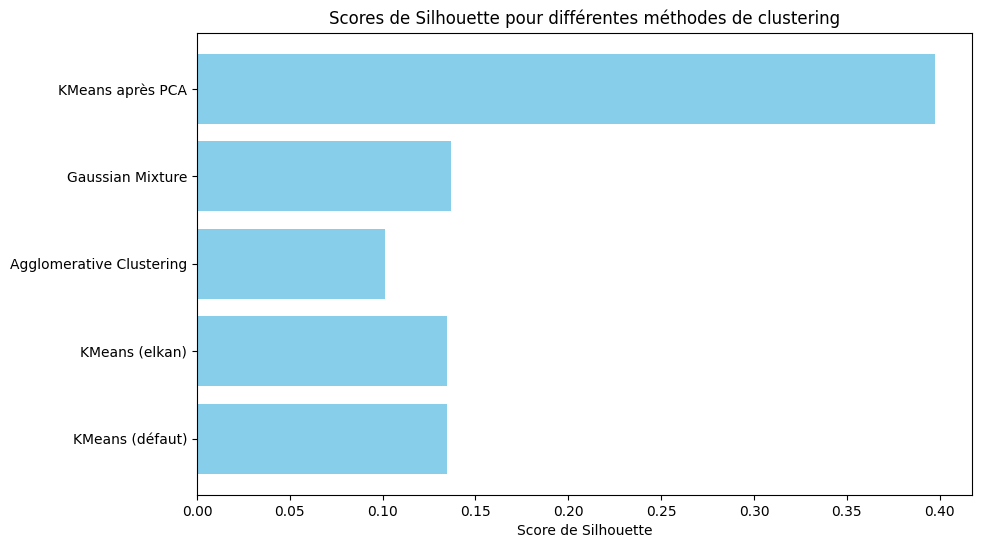

In [103]:
# PCA pour la réduction de la dimensionnalité
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

silhouette_scores = []

# Fonction pour évaluer et stocker les scores de silhouette
def evaluate_clustering(clustering_model, X, description):
    clusters = clustering_model.fit_predict(X)
    if len(set(clusters)) > 1:
        silhouette_avg = silhouette_score(X, clusters)
        print(f"Score de silhouette pour {description} : {silhouette_avg}")
        silhouette_scores.append((description, silhouette_avg))
    else:
        print(f"{description} n'a pas trouvé suffisamment de clusters pour un score de silhouette valide.")


# Application de diverses méthodes de clustering
evaluate_clustering(KMeans(n_clusters=3, random_state=42), X_scaled, "KMeans (défaut)")
evaluate_clustering(KMeans(n_clusters=3, random_state=42, algorithm='elkan'), X_scaled, "KMeans (elkan)")
evaluate_clustering(AgglomerativeClustering(n_clusters=3), X_scaled, "Agglomerative Clustering")
evaluate_clustering(DBSCAN(eps=0.5, min_samples=5), X_scaled, "DBSCAN")
evaluate_clustering(GaussianMixture(n_components=3, random_state=42), X_scaled, "Gaussian Mixture")
evaluate_clustering(KMeans(n_clusters=3, random_state=42), X_pca, "KMeans après PCA")

# Affichage des scores de silhouette pour comparaison
descriptions, scores = zip(*silhouette_scores)
plt.figure(figsize=(10, 6))
plt.barh(descriptions, scores, color='skyblue')
plt.xlabel('Score de Silhouette')
plt.title('Scores de Silhouette pour différentes méthodes de clustering')
plt.show()



Les résultats élevés du KMmans utilisant la PCA pourraient provenir du fait que la PCA élimine le bruit et les caractéristiques superflues.
Au final, le meilleur modèle ici est KMeans, mais en utilisant PCA.
On peut se poser la question : quel pourrait être le score des autres modèles grâce à cette amélioration ?

Score de silhouette pour KMeans après PCA : 0.397555560826798
Score de silhouette pour Agglomerative Clustering après PCA : 0.36985359795294565
Score de silhouette pour DBSCAN après PCA : 0.17487875860499524
Score de silhouette pour Gaussian Mixture après PCA : 0.36622657771151057


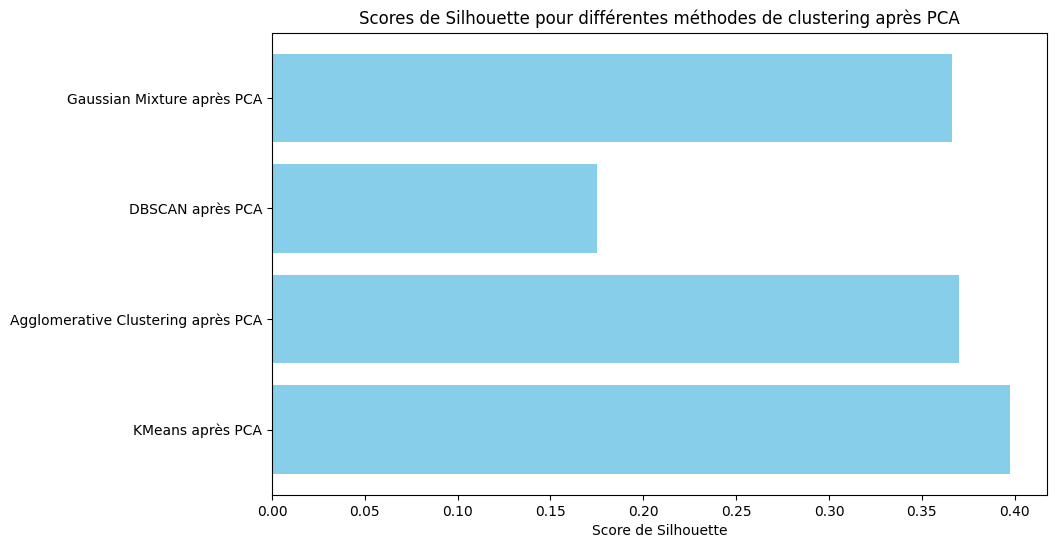

In [104]:
# Appliquer diverses méthodes de clustering après PCA 
silhouette_scores = []
evaluate_clustering(KMeans(n_clusters=3, random_state=42), X_pca, "KMeans après PCA")
evaluate_clustering(AgglomerativeClustering(n_clusters=3), X_pca, "Agglomerative Clustering après PCA")
evaluate_clustering(DBSCAN(eps=0.5, min_samples=5), X_pca, "DBSCAN après PCA")
evaluate_clustering(GaussianMixture(n_components=3, random_state=42), X_pca, "Gaussian Mixture après PCA")

# Affichage des scores de silhouette pour comparaison
descriptions, scores = zip(*silhouette_scores)
plt.figure(figsize=(10, 6))
plt.barh(descriptions, scores, color='skyblue')
plt.xlabel('Score de Silhouette')
plt.title('Scores de Silhouette pour différentes méthodes de clustering après PCA')
plt.show()

Conclusion : \
Finalement KMeans garde le meilleur score de silhouette.\
Mais les résultats restent assez faibles.\
"Score de silhouette pour KMeans après PCA : 0,397", toujours inférieur à 0,5.\
Nous pourrions explorer d’autres alternatives pour obtenir un score plus élevé.\
Par exemple en utilisant PCA pour réduire à plus de 2 le nombre de composantes conservées.\
Enfin, nous avons utilisé ici le score de silhouette comme métrique, mais nous aurions également pu en utiliser d'autres pour comparer les différents modèles.